# Nettoyage des données Preprocessing

On commence par importer les modules utiles :

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score
from sklearn.preprocessing import normalize

On importe les base de données qui sont au format csv :

In [ ]:
carac = pd.read_csv("carac.csv",sep=';')
lieux = pd.read_csv("lieux.csv",sep=';')
veh = pd.read_csv("veh.csv",sep=';')
vict = pd.read_csv("vict.csv",sep=';')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Voyons à quoi les tableaux ressemblent :

In [ ]:
vict.head()

,Num_Acc,place,catu,grav,sexe,trajet,secu,locp,actp,etatp,an_nais,num_veh
0,201800000001,1.0,1,3,1,0.0,11.0,0.0,0.0,0.0,1928.0,B01
1,201800000001,1.0,1,1,1,5.0,11.0,0.0,0.0,0.0,1960.0,A01
2,201800000002,1.0,1,1,1,0.0,11.0,0.0,0.0,0.0,1947.0,A01
3,201800000002,NaN,3,4,1,0.0,2.0,2.0,3.0,1.0,1959.0,A01
4,201800000003,1.0,1,3,1,5.0,21.0,0.0,0.0,0.0,1987.0,A01


Il faut maintenant regrouper toutes les données dans un même tableau :

In [ ]:
victime = vict.merge(veh,on=['Num_Acc','num_veh'])

Carac et Lieux donnent pour chaque accident les caractéristiques de l'accident et du lieu. Veh donne les caractéristiques du véhicule pour tous les véhicules impliqués dans un des accidents. Vict donne des informations pour chaque victime impliqué dans un accident.

On commence par réunir carac et lieux dans un même dataframe suivant la colonne qui identifie l'accident.

Toutes les transformations faites sur la base d'entraînement doivent être faites sur la base de test.

In [ ]:
accident = carac.merge(lieux,on = 'Num_Acc')
victime = victime.merge(accident,on='Num_Acc')

## Gestion des valeurs manquantes

In [ ]:
x=victime.isna().sum()

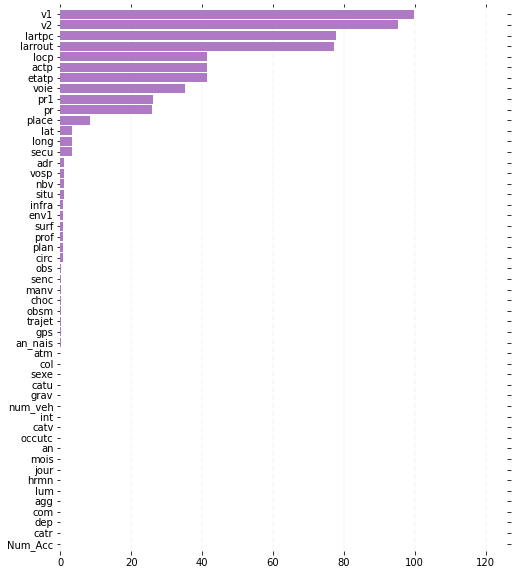

In [ ]:
x=x.sort_values(ascending=True)*100/127951

ax = x.plot(kind='barh', figsize=(8, 10), color='#AF7AC5', zorder=2, width=0.85)

  # Despine
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.tick_params(axis="both", which="both", bottom="off", top="off", labelbottom="on", left="off", right="off", labelleft="on")
vals = ax.get_xticks()
for tick in vals:
  ax.axvline(x=tick, linestyle='dashed', alpha=0.4, color='#eeeeee', zorder=1)

In [ ]:
victime_test.isna().sum()

Num_Acc       0
place       234
catu          0
sexe          0
trajet        0
secu         75
locp       1595
actp       1592
etatp      1593
an_nais       0
num_veh       0
senc          4
catv          0
occutc        0
obs           2
obsm          2
choc          3
manv          2
an            0
mois          0
jour          0
hrmn          0
lum           0
agg           0
int           0
atm           0
col           0
com           0
adr          24
gps           0
lat          11
long         11
dep           0
catr          0
voie       1423
v1         2218
v2         2176
circ          5
nbv           9
pr          469
pr1         466
vosp          7
prof          2
plan          2
lartpc     1800
larrout    1800
surf          2
infra         0
situ          0
env1          0
dtype: int64

In [ ]:
nans = ['v1','v2','lartpc','larrout','locp','etatp','actp','voie','pr1','pr','place']

victime = victime.drop(columns = nans)
victime_test = victime_test.drop(columns = nans)

In [ ]:
victime = victime.dropna()

## Features selection et encodage

### Encodage de hrmn et de la position gps

In [ ]:
hrmn = pd.cut(victime['hrmn'],24,labels=[str(i) for i in range(0,24)])

In [ ]:
victime['hrmn']=hrmn.values

In [ ]:
X_lat = victime['lat']
X_long = victime['long']

X_cluster = np.array((list(zip(X_lat, X_long))))

clustering = KMeans(n_clusters=15, random_state=0)

clustering.fit(X_cluster)

geo = pd.Series(clustering.labels_)
victime['geo']=geo

Avant de continuer, nous pouvons remarquer que nos catégories sont inégalements réparties. Cela peut poser problème au moment de l'entraînement de nos modèles.

In [ ]:
y = victime['grav']
values = np.unique(y,return_counts=True)[1]

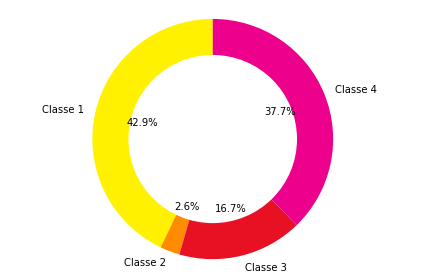

In [ ]:
labels = ['Classe 1','Classe 2','Classe 3','Classe 4']
sizes = values

# Choix des couleurs

colors =['#fff100','#ff8c00','#e81123','#ec008c']
 
# Construction du diagramme et affichage des labels et des #fréquences en pourcentage

fig1, ax1 = plt.subplots()
ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)

# Tracé du cercle au milieu

centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# Affichage du diagramme

ax1.axis('equal')  
plt.tight_layout()
plt.show()

### Calcul des variances et des corrélations

In [ ]:
victime.corr()

,Num_Acc,catu,grav,sexe,trajet,secu,an_nais,senc,catv,occutc,obs,obsm,choc,manv,an,mois,jour,lum,agg,int,atm,col,com,lat,long,dep,catr,circ,nbv,vosp,prof,plan,surf,infra,situ,env1,geo
Num_Acc,1.000000,-0.059608,0.007463,-0.037599,-0.051234,0.045123,0.051263,0.085068,0.065689,-0.024625,-0.110849,0.081963,0.037329,0.049037,NaN,0.008558,0.002049,0.074506,0.184903,0.029772,-0.043717,-0.004926,-0.025104,-0.191548,0.305270,0.631945,-0.038099,-0.051917,0.175534,0.054304,-0.089748,-0.159841,-0.043550,-0.015789,0.078552,0.159018,-0.078518
catu,-0.059608,1.000000,0.197321,0.218189,0.056867,-0.135832,0.102705,-0.028232,-0.038387,0.062591,0.028382,-0.136518,-0.040893,-0.044203,NaN,0.077017,-0.000362,0.036021,0.027798,-0.013384,0.008527,0.208109,0.032750,-0.028168,0.024699,-0.041228,0.037150,-0.019662,-0.044116,0.007385,0.000714,0.012478,0.008589,0.004851,0.044150,-0.067427,0.019277
grav,0.007463,0.197321,1.000000,0.087707,-0.016251,0.109156,0.089626,0.005283,0.157185,-0.021630,0.119791,-0.104159,-0.029425,-0.077102,NaN,0.023384,-0.003817,0.031623,-0.024563,-0.007931,-0.008267,0.033894,0.001129,-0.006264,0.002839,-0.008733,-0.009367,-0.003810,0.003828,-0.002958,0.014884,0.045414,0.024233,-0.004292,0.067442,-0.009954,-0.009410
sexe,-0.037599,0.218189,0.087707,1.000000,0.001197,-0.082808,-0.027234,-0.002019,-0.132765,0.008433,-0.012242,0.000194,0.018952,0.007119,NaN,-0.001400,0.000916,-0.047090,-0.003256,-0.003855,0.021462,0.008682,0.012111,-0.003763,-0.009918,-0.036302,-0.002672,0.004060,-0.015578,-0.009559,-0.000366,-0.002080,0.010917,0.008575,0.000736,-0.007247,0.001703
trajet,-0.051234,0.056867,-0.016251,0.001197,1.000000,-0.025714,-0.018878,0.014402,-0.030805,0.018641,0.055625,-0.038381,0.022401,-0.002235,NaN,-0.015430,-0.004126,0.012353,-0.067212,-0.012903,-0.014396,0.027404,0.057803,-0.024709,0.006214,-0.017790,-0.046095,0.037618,0.004549,-0.016788,0.028544,0.046890,0.001172,-0.001717,0.005987,-0.004121,0.001205
secu,0.045123,-0.135832,0.109156,-0.082808,-0.025714,1.000000,0.074205,-0.007413,0.249924,0.011051,-0.008799,0.024882,-0.003465,0.004767,NaN,-0.077806,0.001028,0.008108,0.076628,0.031029,-0.001917,-0.035643,-0.038743,0.003066,0.000364,0.052820,0.067112,-0.029711,-0.036963,0.034172,-0.011669,-0.015600,-0.002923,0.012529,-0.073121,0.093173,0.014901
an_nais,0.051263,0.102705,0.089626,-0.027234,-0.018878,0.074205,1.000000,0.005990,0.044343,0.024613,0.058218,-0.026377,-0.014385,-0.010590,NaN,0.003617,0.004565,0.131024,0.007353,-0.021060,-0.015486,-0.009759,0.008892,-0.018904,0.025757,0.036597,-0.007176,0.012518,0.020451,0.006146,-0.001823,0.013802,0.018388,-0.018768,0.036530,0.011777,0.002794
senc,0.085068,-0.028232,0.005283,-0.002019,0.014402,-0.007413,0.005990,1.000000,0.008225,0.010274,0.008613,0.017259,0.023235,-0.003415,NaN,-0.045609,-0.012144,-0.004103,-0.163435,-0.084503,0.009029,-0.040908,-0.031755,0.028511,-0.015568,0.038347,-0.261804,0.120990,0.158090,-0.004717,0.019352,-0.004629,-0.003389,-0.020591,-0.064675,0.076344,-0.022759
catv,0.065689,-0.038387,0.157185,-0.132765,-0.030805,0.249924,0.044343,0.008225,1.000000,0.162317,-0.003403,-0.016886,-0.032939,-0.022264,NaN,-0.006564,0.006142,-0.016297,0.053588,0.018424,-0.027296,0.030474,-0.051947,-0.001588,0.013132,0.043046,0.042384,-0.026664,-0.003340,0.034834,-0.003370,0.004217,-0.004635,-0.001217,-0.014497,0.013511,0.006819
occutc,-0.024625,0.062591,-0.021630,0.008433,0.018641,0.011051,0.024613,0.010274,0.162317,1.000000,0.009574,-0.020196,0.012133,-0.019148,NaN,-0.017209,0.011477,-0.003522,-0.002024,0.004076,-0.004108,-0.004782,0.006379,0.005779,-0.005108,-0.010209,-0.006973,0.004155,0.000193,0.051205,0.008426,0.034488,0.012504,0.016764,-0.004076,-0.016325,0.014848


In [ ]:
victime.var()

Num_Acc    2.826551e+08
catu       3.170716e-01
grav       1.862168e+00
sexe       2.159840e-01
trajet     7.149747e+00
secu       1.371715e+02
an_nais    3.470521e+02
senc       5.011156e-01
catv       1.472512e+02
occutc     2.320501e+01
obs        1.087702e+01
obsm       1.255078e+00
choc       5.783945e+00
manv       5.352342e+01
an         0.000000e+00
mois       1.095180e+01
jour       7.617250e+01
lum        2.148682e+00
agg        2.391380e-01
int        3.686596e+00
atm        2.679992e+00
col        3.423295e+00
com        2.987232e+04
lat        4.635970e+11
long       1.079215e+12
dep        8.696434e+04
catr       1.440321e+00
circ       5.342615e-01
nbv        2.008379e+00
vosp       3.260983e-01
prof       3.282731e-01
plan       4.735026e-01
surf       6.914334e-01
infra      1.933951e+00
situ       1.051449e+00
env1       1.350017e+03
geo        1.490863e+01
dtype: float64

La variable *an* a une variance très faible, on peut la retirer :

In [ ]:
victime = victime.drop(columns=['an'])

### Features pour l'encodage One-Hot

In [ ]:
y = victime['grav']

features = ['catu','sexe','trajet','secu',
            'catv','an_nais','mois',
            'occutc','obs','obsm','choc','manv',
            'lum','agg','int','atm','col','gps',
            'catr','circ','vosp','prof','plan',
            'surf','infra','situ','hrmn','geo']

### Encodage et création de la base pour l'entrainement et l'évaluation des modèles

On fait l'encodage avec *get_dummies*

In [ ]:
X_train_data = pd.get_dummies(victime[features].astype(str))

In [ ]:
y.shape, X_train_data.shape

((94745,), (94745, 422))

In [ ]:
victime.columns

Index(['Num_Acc', 'catu', 'grav', 'sexe', 'trajet', 'secu', 'an_nais',
       'num_veh', 'senc', 'catv', 'occutc', 'obs', 'obsm', 'choc', 'manv',
       'mois', 'jour', 'hrmn', 'lum', 'agg', 'int', 'atm', 'col', 'com', 'adr',
       'gps', 'lat', 'long', 'dep', 'catr', 'circ', 'nbv', 'vosp', 'prof',
       'plan', 'surf', 'infra', 'situ', 'env1', 'geo'],
      dtype='object')

In [ ]:
X_train_data.columns

Index(['catu_1', 'catu_2', 'catu_3', 'sexe_1.0', 'sexe_2.0', 'trajet_0.0',
       'trajet_1.0', 'trajet_2.0', 'trajet_3.0', 'trajet_4.0',
       ...
       'geo_14.0', 'geo_2.0', 'geo_3.0', 'geo_4.0', 'geo_5.0', 'geo_6.0',
       'geo_7.0', 'geo_8.0', 'geo_9.0', 'geo_nan'],
      dtype='object', length=422)

In [ ]:
X_train_data['nbv']=victime['nbv']

# Construction des modèles

## 1er modèle : Random forest

### Entraînement

In [ ]:
X_train_data_nn = normalize(X_train_data.values)

X_trainrf, X_testrf, y_trainrf, y_testrf = train_test_split(X_train_data_nn,y)

model_rf1 = RandomForestClassifier(n_estimators=100, 
                                  max_depth=8
                                  )

model_rf1.fit(X_trainrf, y_trainrf)
predictions = model_rf1.predict(X_testrf)

predictions_train = model_rf1.predict(X_trainrf)

train_acc = accuracy_score(y_trainrf, predictions_train)
print(train_acc)
test_acc = accuracy_score(y_testrf, predictions)
print(test_acc)

0.6091221255875482
0.6000337737999747


### Résultats

In [ ]:
from sklearn.metrics import recall_score

recall = recall_score(y_testrf, predictions, average='macro')
print('Recall: %.3f' % recall)

Recall: 0.406


In [ ]:
from sklearn.metrics import recall_score,f1_score

f1 = f1_score(y_testrf, predictions, average='macro')
print('F1-Score: %.3f' % f1)

F1-Score: 0.394


In [ ]:
confusion_matrix(y_trainrf, predictions_train)

array([[35152,   135,  1113,  1088],
       [   17,  2154,    95,    69],
       [  367,   290, 12311,  1719],
       [ 1698,   478,  3829, 26950]])

## 2ème modèle : Gradient Boosting, XGBoost

### Entraînement

In [ ]:
X_train_data_nn = normalize(X_train_data)
X_train, X_test, y_train, y_test = train_test_split(X_train_data_nn,y)

"""
parameters = {
    "loss":["deviance"],
    "learning_rate": [0.1,0.15,0.2,0.25,0.3],
    "max_depth":[5],
    "max_features":["sqrt"],
    "criterion": ["mae"],
    "subsample":[0.8,0.9],
    "n_estimators":[200,300]
    }

model_boosting = GridSearchCV(GradientBoostingClassifier(), parameters)
"""

model_boosting2 = GradientBoostingClassifier(loss="deviance",
    learning_rate=0.2,
    max_depth=5,
    max_features="sqrt",
    subsample=0.95,
    n_estimators=200)

model_boosting2.fit(X_train, y_train)

predictions = model_boosting2.predict(X_test)
predictions_train = model_boosting2.predict(X_train)

train_acc = accuracy_score(y_train, predictions_train)
print(train_acc)
test_acc = accuracy_score(y_test, predictions)
print(test_acc)

0.7038929857657349
0.6596583893538208


### Résultats

In [ ]:
f1 = f1_score(y_test, predictions, average='macro')
print('F1-Score: %.3f' % f1)

F1-Score: 0.489


In [ ]:
confusion_matrix(y_test, predictions)

array([[12484,     0,     0,     0],
       [    0,   791,     0,     0],
       [    0,     0,  4983,     1],
       [    1,     0,     0, 10896]])

### Matrice de confusion

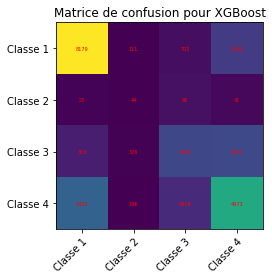

In [ ]:
fig, ax = plt.subplots()

#S=confusion_matrix(y_test, predictions)
img = ax.imshow(S)

x_label_list = ['Classe 1','Classe 2','Classe 3','Classe 4']

ax.set_xticks(np.arange(4))
ax.set_yticks(np.arange(4))

ax.set_xticklabels(x_label_list,rotation ='vertical',verticalalignment='top')
ax.set_yticklabels(x_label_list)

ax.set_title("Matrice de confusion pour XGBoost")

cmap = plt.cm.get_cmap('Greens')

for i in range(len(x_label_list)):
    for j in range(len(x_label_list)):
        text = ax.text(j, i, round(S[j,i],3),fontsize=5,
                       ha="center", va="center", color="r")

plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.tight_layout()
#plt.savefig('similarity.png',)
plt.show()